In [51]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

In [21]:
csv_file = "./processed.csv"
df = pd.read_csv(csv_file)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print(df)

           照片 Picture 品牌 Brand 衣服長度 Clothes Length  價格 Price  \
0     image_00000.jpg      H&M             短 short       499   
1     image_00001.jpg      H&M              長 long       999   
2     image_00002.jpg      H&M              長 long       699   
3     image_00003.jpg      H&M              長 long       999   
4     image_00004.jpg      H&M              長 long       699   
...               ...      ...                 ...       ...   
2228  image_02228.jpg    Lativ             短 short       199   
2229  image_02229.jpg    Lativ             短 short       299   
2230  image_02230.jpg    Lativ             短 short       249   
2231  image_02231.jpg    Lativ             短 short       499   
2232  image_02232.jpg    Lativ             短 short       590   

      西裝褲、裙 dress pants、skirt  背心 Vest  牛仔褲/裙 jeans / demi skirt  \
0                         0.0      0.0                       0.0   
1                         0.0      0.0                       0.0   
2                         0

In [35]:
from sklearn.preprocessing import OneHotEncoder

target = "價格 Price"
# print(df)
y = df[target]
image_dir = "./clothes_data"
df["filepath"] = df["照片 Picture"].apply(lambda x: os.path.join(image_dir, f"{x}"))
X = df
X = X.drop(columns=[target, "照片 Picture"])  # Features

# remove invalid datas

X = pd.get_dummies(X, columns=["品牌 Brand"])
X = pd.get_dummies(X, columns=["衣服長度 Clothes Length"])
print(X.columns)

Index(['西裝褲、裙 dress pants、skirt', '背心 Vest', '牛仔褲/裙 jeans / demi skirt',
       '工裝褲/裙 cargo pants/skirt', '上半身 Top', '吊帶褲/裙 overalls/jumper skirt',
       '羽絨衣 Down coat / jacket', '網紗 Mesh', '裙子 skirt', '毛衣、針/織衣 Sweater',
       '西裝 Suit', '緊身褲 leggings', '休閒褲/裙 casual pants/skirt', '洋裝 Dress',
       'Shirt', '運動褲/裙 sweat pants / sports skirt', '下半身 Bottom', '外套 Jacket',
       '毛衣、針織衣 Sweater', '百褶裙 pleated skirt', '連帽衣 Hoodie', '牛仔材質 Denim',
       'T-Shirt', '褲子 pants', '運動材質 Sport Tops', 'filepath',
       '品牌 Brand_50 percent', '品牌 Brand_AIR SPACE', '品牌 Brand_Adidas',
       '品牌 Brand_GAP', '品牌 Brand_H&M', '品牌 Brand_Lativ', '品牌 Brand_Net',
       '品牌 Brand_New Balance', '品牌 Brand_Nike', '品牌 Brand_PAZZO',
       '品牌 Brand_Puma', '品牌 Brand_Under Armour', '品牌 Brand_Uniqlo',
       '衣服長度 Clothes Length_短 short', '衣服長度 Clothes Length_長 long'],
      dtype='object')


In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_height, img_width = 180, 180
image_shape = (img_height, img_width, 3)


def load_and_preprocess_image(filepath):
    img = load_img(filepath, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


X_train_images = np.array([load_and_preprocess_image(fp) for fp in X_train["filepath"]])
X_test_images = np.array([load_and_preprocess_image(fp) for fp in X_test["filepath"]])

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train.drop("filepath", axis=1))
X_test_features = scaler.transform(X_test.drop("filepath", axis=1))

In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


In [55]:
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    Concatenate,
)
from tensorflow.keras.models import Model

image_input = Input(shape=image_shape, name="Image_Input")
x = Conv2D(32, (3, 3), activation="relu")(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

feature_input = Input(shape=(X_train_features.shape[1],), name="Feature_Input")
y = Dense(64, activation="relu")(feature_input)
y = Dropout(0.3)(y)

combined = Concatenate()([x, y])
z = Dense(64, activation="relu")(combined)
z = Dropout(0.5)(z)
output = Dense(1)(z)

model = Model(inputs=[image_input, feature_input], outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"]
)

# Train the model
history = model.fit(
    [X_train_images, X_train_features],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_test_images, X_test_features], y_test),
    verbose=1,
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 3487142.0000 - mae: 1312.1323 - val_loss: 1615165.7500 - val_mae: 865.6996
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 2398526.2500 - mae: 1101.7369 - val_loss: 1567911.1250 - val_mae: 1007.7355
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 1940544.7500 - mae: 976.3538 - val_loss: 1343704.8750 - val_mae: 905.9395
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 1825451.2500 - mae: 953.1118 - val_loss: 1113864.5000 - val_mae: 778.8088
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 1541466.0000 - mae: 863.6235 - val_loss: 1041648.4375 - val_mae: 673.7465
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 1467871.3750 - mae: 824.8968 - val_loss: 1033924.0625 - val_mae: 713.8030
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 1425960.3750 - mae: 808.9849 - val_loss: 934060.6250 - val_mae: 658.9287
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 129432

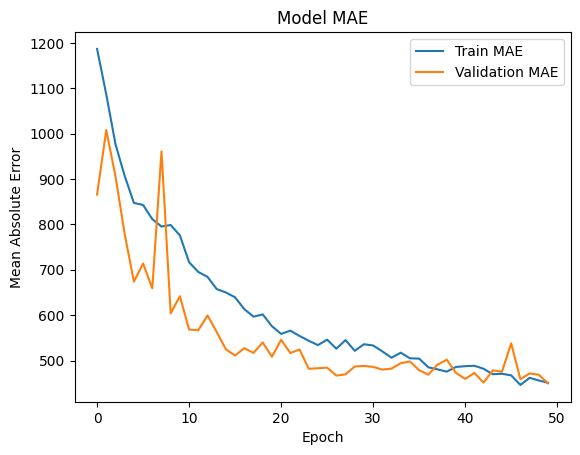

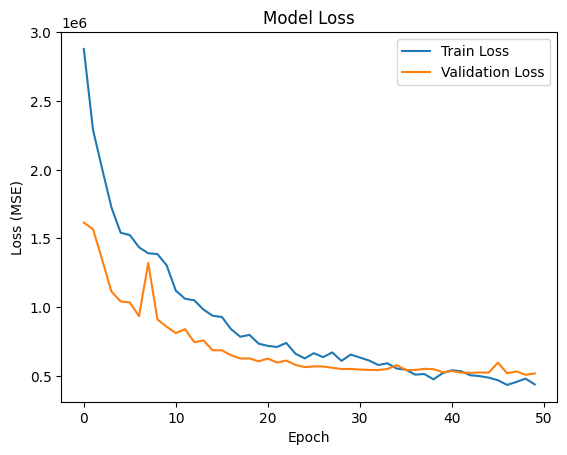

In [57]:
import matplotlib.pyplot as plt

# Plot training & validation mean absolute error values
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Model MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend(loc="upper right")
plt.show()

In [58]:
y_pred = model.predict([X_test_images, X_test_features]).flatten()

C:\Users\doo12\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_83. Received: the structure of inputs=('*', '*')
  warnings.warn(


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_19" is incompatible with the layer: expected axis -1 of input shape to have value 25088, but received input with shape (32, 51200)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(32, 180, 180, 3), dtype=float32)', 'tf.Tensor(shape=(32, 40), dtype=float32)')
  • training=False
  • mask=('None', 'None')

In [ ]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mae:", mae)
print("mse:", mse)
print("mape:", mape)
print("r2:", r2)

mae: 359.6969369636553
mse: 370491.67038723046
mape: 0.2656286586475834
r2: 0.7656298279762268
